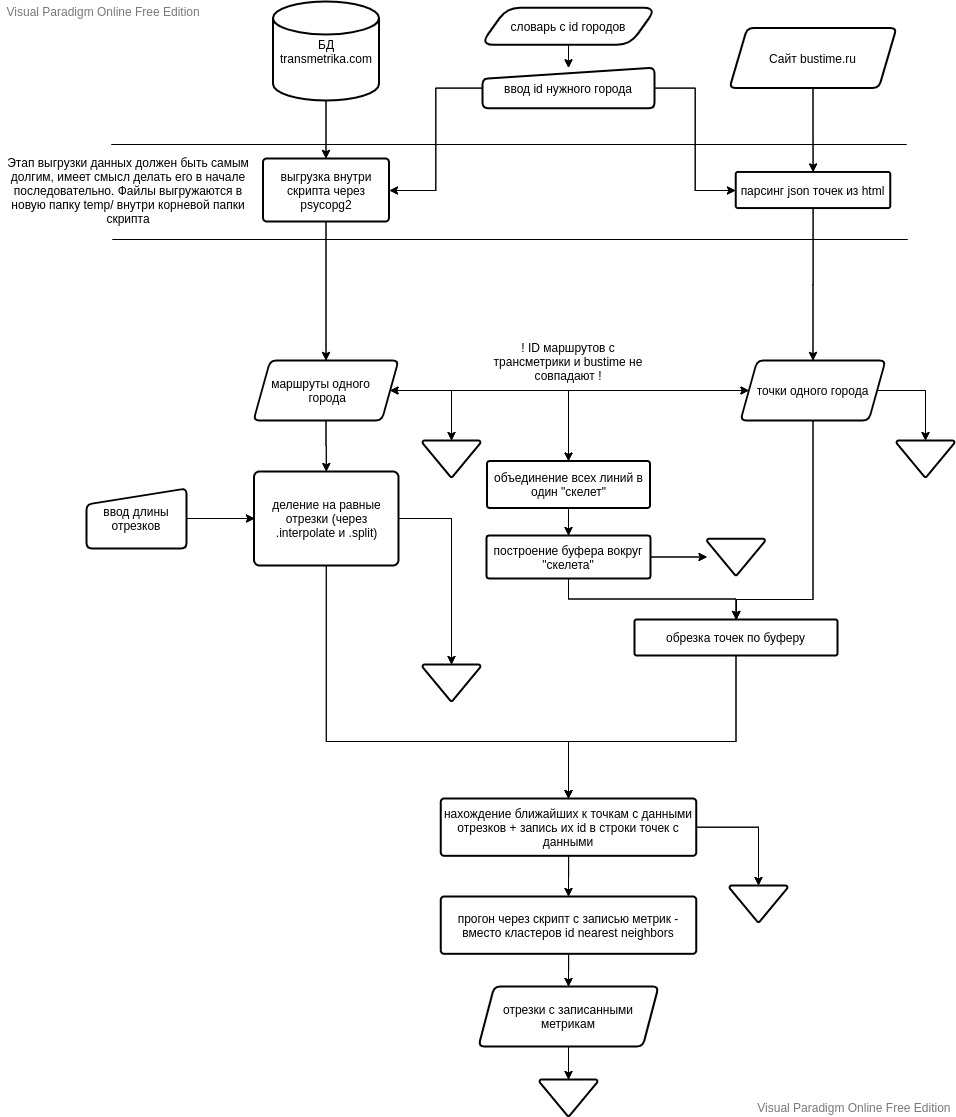

In [ ]:
import json
import psycopg2
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import time
import geojson
from geojson import Feature, FeatureCollection, Point
import datetime

<br>**В блоках ниже происходит работа с БД сайта transmetrika.com, формируется словарь для кодирования городов и выгружается сетка маршрутов выбранного города**

<br>To-do:
1) Нормальная система папок (с корневой и temp/)
<br>2) Проверка наличия локального файла маршрута через try

In [ ]:
# выгрузка маршрутов из БД трансметрики

db_host = input('enter DB host: ')
db_port = input('enter DB port: ')
db_name = input('enter DB name: ')
db_user = input('enter user name: ')
db_pass = input('enter password: ')


con = psycopg2.connect(database=db_name, 
                       user=db_user, 
                       password=db_pass, 
                       host=db_host, 
                       port=db_port
                      )

In [ ]:
# коннектимся к БД, выбираем id и названия городов

cur = con.cursor()
cur.execute('SELECT id,name FROM cities')
cities_list = cur.fetchall()


# формируем словарь, через который города будут кодироваться по id

cities_dict = {}

for i in range(len(cities_list)):
    cities_dict[cities_list[i][0]] = cities_list[i][1]
    
    
# выводим словарь в челoвеко-читаемом формате
    
for key in sorted(cities_dict):
    print("%s: %s" % (key, cities_dict[key]))

In [ ]:
# выбираем город для анализа

city_choice_flag = False

while city_choice_flag == False:
    city_id = int(input('Введите номер нужного города: '))
    print('Выбранный город -',cities_dict[city_id]+'?')
    c_choice = input('y/д - Да\n')
    if c_choice == 'y' or c_choice == 'д':
        city_choice_flag = True
        print('Выбран город',cities_dict[city_id])
    else:
        city_choice_flag = False

In [ ]:
# выгружаем маршруты нужного города из БД

con.rollback()
cur.execute('SELECT id,route_number,route_name,type_of_transport,geo_data FROM routes WHERE city_id=%s',(str(city_id)))
db_routes = cur.fetchall()

In [ ]:
# упаковываем маршруты в geojson, за код спасибо Никите

routes_collection = {
                    'type': 'FeatureCollection',
                    'features': []
                    }

for i in range(len(db_routes)):
    _id = db_routes[i][0]
    code = db_routes[i][1]
    name = db_routes[i][2]
    transport_type = db_routes[i][3]
    geometry = db_routes[i][4]

    feature = {
        "type": "Feature",
        "properties":{
            "id":_id,
            "code":code,
            "name":name,
            "transport_type":transport_type
        },
        "geometry":geometry
    }
    
    routes_collection['features'].append(feature)

In [ ]:
# выгружаем в geojson

output_filename = 'db_routes_'+str(city_id)+'.geojson'

with open(output_filename, 'w') as output:
    json.dump(routes_collection, output)
    
print('Маршруты города',cities_dict[city_id],'выгружены в файл',output_filename) # добавить папку


# после этого БД нам больше не нужна, закрываем подключение 

con.close()

**_________________________________________________**<br><br><br>**В блоках ниже происходит работа с bustime.ru**
<br><br>To-do:
<br>~~1) Выгрузка названий городов и сопоставление их с id из словаря трансметрики~~
<br>~~2) Batch-выгрузка данных за несколько дней, выбор диапазона дней,~~ скан ненулевых дней

In [ ]:
# прописываем хост бастайма и параметры браузера

HOST = 'https://www.bustime.ru/'
HEADERS = {'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
           'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36'}


# запрашиваем html главной страницы

def get_html(url, params=''):
    
    """ Возвращает html файл по URL """
    
    req = requests.get(url, headers=HEADERS, params=params)
    return req

host_html = get_html(HOST)


# парсим элементы из выпадающего списка городов

soup = BeautifulSoup(host_html.text)
res = soup.find(class_="ui search selection dropdown").find_all(class_="item")


# делаем список городов

bt_cities = {} # словарь bustime "город-ссылка"

for i in range(len(res)):
    bt_cities[res[i].getText().strip('\n ')] = res[i]['href']
    
    
# получаем ссылку на журнал соответствующего города

CITY_URL = HOST.rstrip('/') + bt_cities[cities_dict[city_id]] + 'transport/'

# В базе трансметрики нужно убрать дефис у Нижнего Новгорода, иначе скрипт не будет работать в нём

(можно поставить костыль и изменить название в каком-нибудь из словарей)

In [ ]:
date_now = datetime.date.today() # сегодняшняя дата
print('Сегодня',date_now)

date_span_valid = False

while date_span_valid == False:
    date_span = int(input('Введите период анализа (начиная с сегодняшнего дня, максимум - 7 дней): '))
    if date_span <= 7 and date_span > 0:
        print('Период анализа =',date_span,'дней')
        date_span_valid = True
    else:
        print('Введите подходящий период')

date_list = [] # делаем список нужных дат

for i in range(date_span):
    date_list.append(date_now - i*datetime.timedelta(days=1))
    
date_url_list = [] # генерируем список ссылок на страницы с нужными датами

for i in range(date_span):
    date_url_list.append(CITY_URL+str(date_list[i]))

In [ ]:
# собираем список ссылок на страницы

page_hrefs = [] # список ссылок на страницы

for i in date_url_list:
    date_html = get_html(i)
    soup = BeautifulSoup(date_html.text)
    for a in soup.find_all('a'):
        if a['href'].find('page') != -1:
            page_hrefs.append(a['href'])

In [ ]:
# собираем список ссылок на ТС

bus_hrefs = []

for i in page_hrefs:
    page_html = get_html(HOST+i)
    soup = BeautifulSoup(page_html.text)
    for a in soup.find_all('a'):
        if a['href'].find('page') == -1 and a['href'].find('/transport/2021-') != -1: # исключаем из выборки ненужные ссылки
            bus_hrefs.append(a['href'])
            print('добавлена ссылка',a['href'])
print('Ссылки скачаны, n='+str(len(bus_hrefs)))

In [ ]:
def geojsonize(_list, route_num, route_date):
    #features=[]
    for i in range(len(_list)):
        temp_json = json.loads(_list[i])
        geometry = [float(temp_json["lon"].replace(',','.')),
                    float(temp_json["lat"].replace(',','.'))]
        props = {"uid":temp_json["uniqueid"],
                 "gosnum":temp_json["gosnum"],
                 "bortnum":temp_json["bortnum"],
                 "date":route_date,
                 "timestamp":temp_json["timestamp"],
                 "bus_id":temp_json["bus_id"],
                 "heading":temp_json["heading"],
                 "speed":temp_json["speed"],
                 "direction":temp_json["direction"],
                 "route_number":route_num}
        features.append(Feature(geometry=geojson.Point((float(temp_json["lon"].replace(',','.')), 
                                                        float(temp_json["lat"].replace(',','.')))),
                                properties=props))
    #feature_collection.append(FeatureCollection(features))
    
    print('200')

In [ ]:
_replace = {'\\':' ',
           'var track = ':'',
           "'":'"',
           'uniqueid':'"uniqueid"',
           'gosnum':'"gosnum"',
           'bortnum':'"bortnum"',
           'timestamp':'"timestamp"',
           'bus_id':'"bus_id"',
           'heading':'"heading"',
           'speed':'"speed"',
           'lon':'"lon"',
           'lat':'"lat"',
           'direction':'"direction"',
           '[':'',
           ']':'',
           'parseFloat( ':'',
           '.replace( ", ", ". ") )':'',
           ' ':'',
           '},{':'}, {'}

def mult_replace(text, dict_):
    for i,j in dict_.items():
        text = text.replace(i, j)
    return text

In [ ]:
cnt = 0
fail = 0 
features = []
exec_time = 0

for i in range(len(bus_hrefs)):
# for i in range(3): дебаг строка
    
    start = time.perf_counter() # заводим таймер итерации
    
    try:
        route_html = get_html(HOST+bus_hrefs[i]) # запрашиваем html отдельного ТС
        soup = BeautifulSoup(route_html.text, 'html.parser') 
        print('\n\nHTML найден')
        
    except:
        print(route_html,'не отвечает')
        
    test_bc = soup.find(class_='ui breadcrumb').find_all(class_='section') # парсим элемент с датой и номером тс
    uid = bus_hrefs[i].split('/')[4] # id ТС
    route_date = test_bc[2].getText() # дата
    route_num = test_bc[3].getText() # номер маршрута
    print('Дата:',route_date,'Маршрут:',route_num,'ID ТС:',uid)
    
    script = soup.find_all('script') # парсим скрипт из html
    print('Скрипт ТС',uid,'найден')
    
    var = re.compile(r"var (.*);",re.DOTALL) # в этом блоке происходит магия 
    result = re.findall(var,str(script)) # парсятся регулярные выражения, начинающиеся с var
    result_list = str(result).split(';') # делятся по точкам с запятой в список
    track_line = result_list[3] # отбирается нужный var с json внутри
    temp_new = track_line.split('\\n') # делаем нормальное построчное деление
    temp_new = ''.join(temp_new) # склеиваем обратно в валидный (наверное) json
    print('JSON ТС',uid,'скачан')
    
    points_list = mult_replace(temp_new, _replace).split(', ') # проводим замену элементов, на которые json ругается
    points_list[-1] = points_list[-1].rstrip(',') # убираем лишнюю запятую из конца списка
    
    print('ТС',uid+'. Статус:')
    try:
        geojsonize(points_list, route_num, route_date) # делаем из полученных данных валидный geojson
        print('\n',str(round(cnt/len(bus_hrefs)*100,1))+'%')
        cnt += 1
    except:
        print('\t\t\t\tFail')
        cnt += 1
        fail += 1
        continue
    stop = time.perf_counter() # останавливаем таймер
    exec_time += (stop-start) # добавляем время итерации к общему времени
    print('Время выполнения =',round(stop-start, 2),', ET =', 
           round((exec_time/(i+1))*len(bus_hrefs)-exec_time,2))
        
print('\n\nПроцесс выполнен, успешно =',cnt,'ошибка =',fail)

In [ ]:
# кодировка названия: points_*id города*_*сегодняшняя дата*_*период*d.geojson

feature_collection = []
feature_collection.append(FeatureCollection(features))
with open('points_'+str(city_id)+'_'+str(datetime.date.today())+'_'+str(date_span)+'d'+'.geojson', 'w',encoding='utf8') as f:
        geojson.dump(feature_collection[0], f,ensure_ascii=False)